# Monte Carlo simulation of the folded incoherent noise distribution

One of the question that we have from our analysis is that the sky-subtracted incoherently-averaged (over antennas) noise spectrum (INS) of the MeerKLASS autocorrelation visibility does not produce the expected folded Gaussian distribution. This maybe caused by the fact that we do not have enough number of antennas. Specifically, the incoherent averaging over many baselines, or in our cases antennas, in the SSINS algorithm is what leads to the expected noise distribution following the central limit (CLT) theorem. This is derived for cross-correlation in Wilensky et al. (2019). As we only have ~60 antennas to average over, this may or may not be enough for the CLT to kick in. In attempt to figure this out, we will perform a simple Monte Carlo simulation by drawing from a folded Gaussian distribution (first with no mock RFI for simplicity) 60 times, averaged over the mock noise spectrum, and then look at the z-score distribution.

In [1]:
import numpy as np

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import foldnorm
from mkssins import *

First, set up a somewhat realistic observation parameters for the simulation. Since we are simulating noise, we do not have to be specific about the time and frequency dimentions, but the total number of data points matter.

In [2]:
nruns = 100
nants = 60
ntimes = 3647
nfreqs = 4096
shape = (3647, 4096)
nsamples = ntimes * nfreqs

# Final z-score (cumulative of 100 runs)
z_score_all_runs = np.zeros((nruns, ntimes, nfreqs))

We will first simulate the non-zero mean Guassian Distributions of the Sky-Subtraction Spectrums. Each sky-subtracted distributions will have the shape (Ntimes, Nfreqs).

Now we will loop over the antennas to get the sky-subtractions for each antenna

In [3]:
sky_subs = np.zeros((nants, ntimes, nfreqs))
for ant in range(nants):
    ss = 0.01 * np.random.normal(loc=0.01, scale=2, size=shape)
    sky_subs[ant] = ss

In [7]:
sky_subs.shape

(60, 3647, 4096)

In [8]:
sky_subs[0][:, 3560]

array([ 0.01398835,  0.00260484,  0.01331391, ...,  0.01664453,
       -0.02280598,  0.00353089])

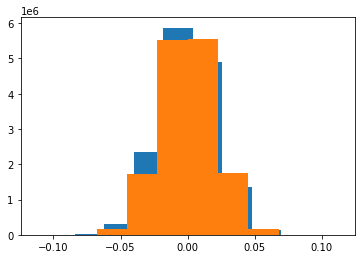

In [9]:
plt.hist(np.ravel(sky_subs[0]))
plt.hist(np.ravel(sky_subs[4]))
plt.show()

In [10]:
def rms_cal(ss_data):
    N = ss_data.shape[0]
    rms_all = np.sqrt(np.nanmean((ss_data)**2)/N)
    return rms_all
    

In [11]:
rms = rms_cal(sky_subs[0])
rms

0.0003310875294977494

In [12]:
rms = np.zeros((nants))
for ant in range(sky_subs.shape[0]):
    rms_value = rms_cal(sky_subs[ant])
    rms[ant] = rms_value

In [13]:
rms.shape

(60,)

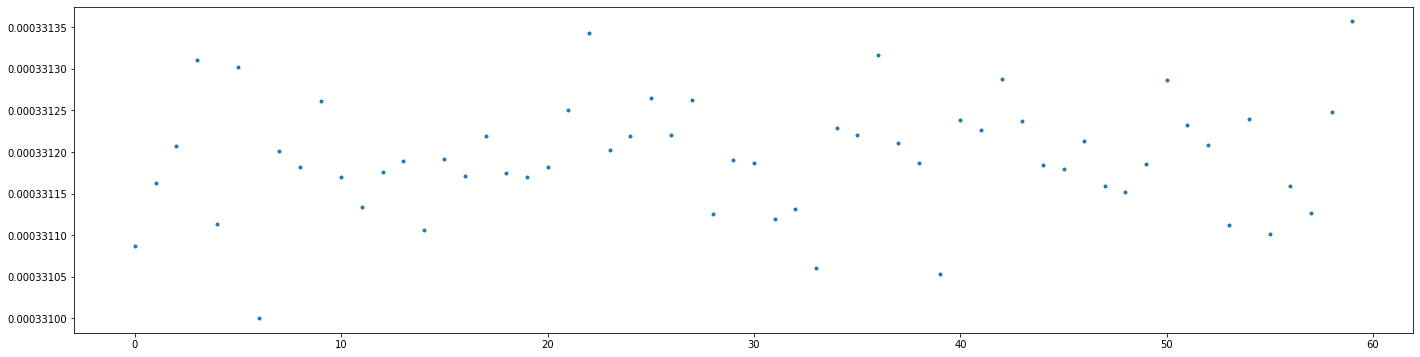

In [14]:
fig, ax = plt.subplots(1, figsize=(24,6))
plt.plot(np.arange(nants), rms, '.')


Take the absolute value of each sky-subtraction. 

In [5]:
NS = np.abs(sky_subs)

Plot one of the noise spectrum just to make sure that the distribution is folded normal

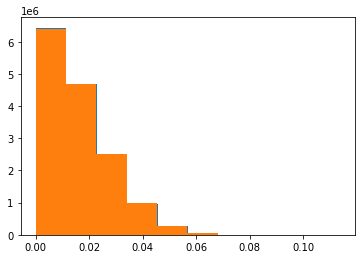

In [16]:
plt.hist(np.ravel(NS[0]))
plt.hist(np.ravel(NS[4]))
plt.show()

Average over antennas (1st axis) to produce the incoherntly-averaged noise spectrum

Now, average over the folded Normal distributions into an array of shape (ntimes, nfreqs) to make a mock incoherent noise spectrum. Note that this is equivalent to the absolute value of the (perfectly) sky-subtracted autocorrrelation (with no RFI).

In [6]:
INS = np.mean(NS, axis=0)

In [8]:
with open('ins_60.npy', 'wb') as f:
    np.save(f, INS)

with open('ins_60.npy', 'rb') as f:
    INS_60 = np.load(f)

(array([2.280000e+02, 2.961700e+04, 6.796360e+05, 3.754897e+06,
        6.160655e+06, 3.490876e+06, 7.519320e+05, 6.757500e+04,
        2.630000e+03, 6.600000e+01]),
 array([0.00834618, 0.01003773, 0.01172927, 0.01342081, 0.01511235,
        0.01680389, 0.01849543, 0.02018698, 0.02187852, 0.02357006,
        0.0252616 ]),
 <BarContainer object of 10 artists>)

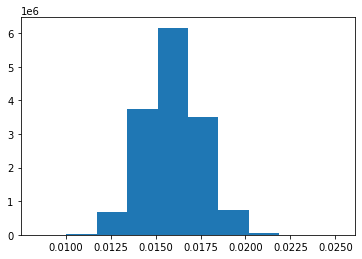

In [20]:
plt.hist(np.ravel(INS_197))

Now, calculate and plot the z-score, making sure we have the right normalisation when doing so

In [9]:

c_fold = np.pi / 2 - 1                           
meanEst = np.mean(INS, axis=0)                      
std_sq = c_fold*meanEst**2 

z_score = ((INS-meanEst))/np.sqrt(std_sq/nants)


In [22]:
z_score.shape

(3647, 4096)

In [10]:
with open('zscore_60.npy', 'wb') as f:
    np.save(f, z_score)

with open('zscore_60.npy', 'rb') as f:
    zscore_60 = np.load(f)

(array([2.380000e+02, 3.080100e+04, 7.025940e+05, 3.830666e+06,
        6.173285e+06, 3.418970e+06, 7.167860e+05, 6.235500e+04,
        2.360000e+03, 5.700000e+01]),
 array([-4.88654482, -3.79609954, -2.70565425, -1.61520897, -0.52476369,
         0.5656816 ,  1.65612688,  2.74657216,  3.83701745,  4.92746273,
         6.01790801]),
 <BarContainer object of 10 artists>)

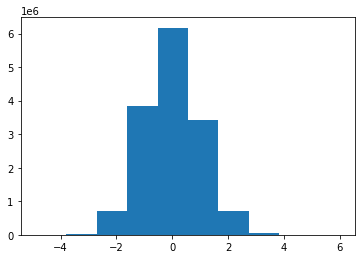

In [24]:
plt.hist(np.ravel(z_score))

In [25]:
## Plotting the Mean Est

In [26]:
meanEst = np.mean(INS, axis=0) 

In [138]:
meanEst.shape


(4096,)

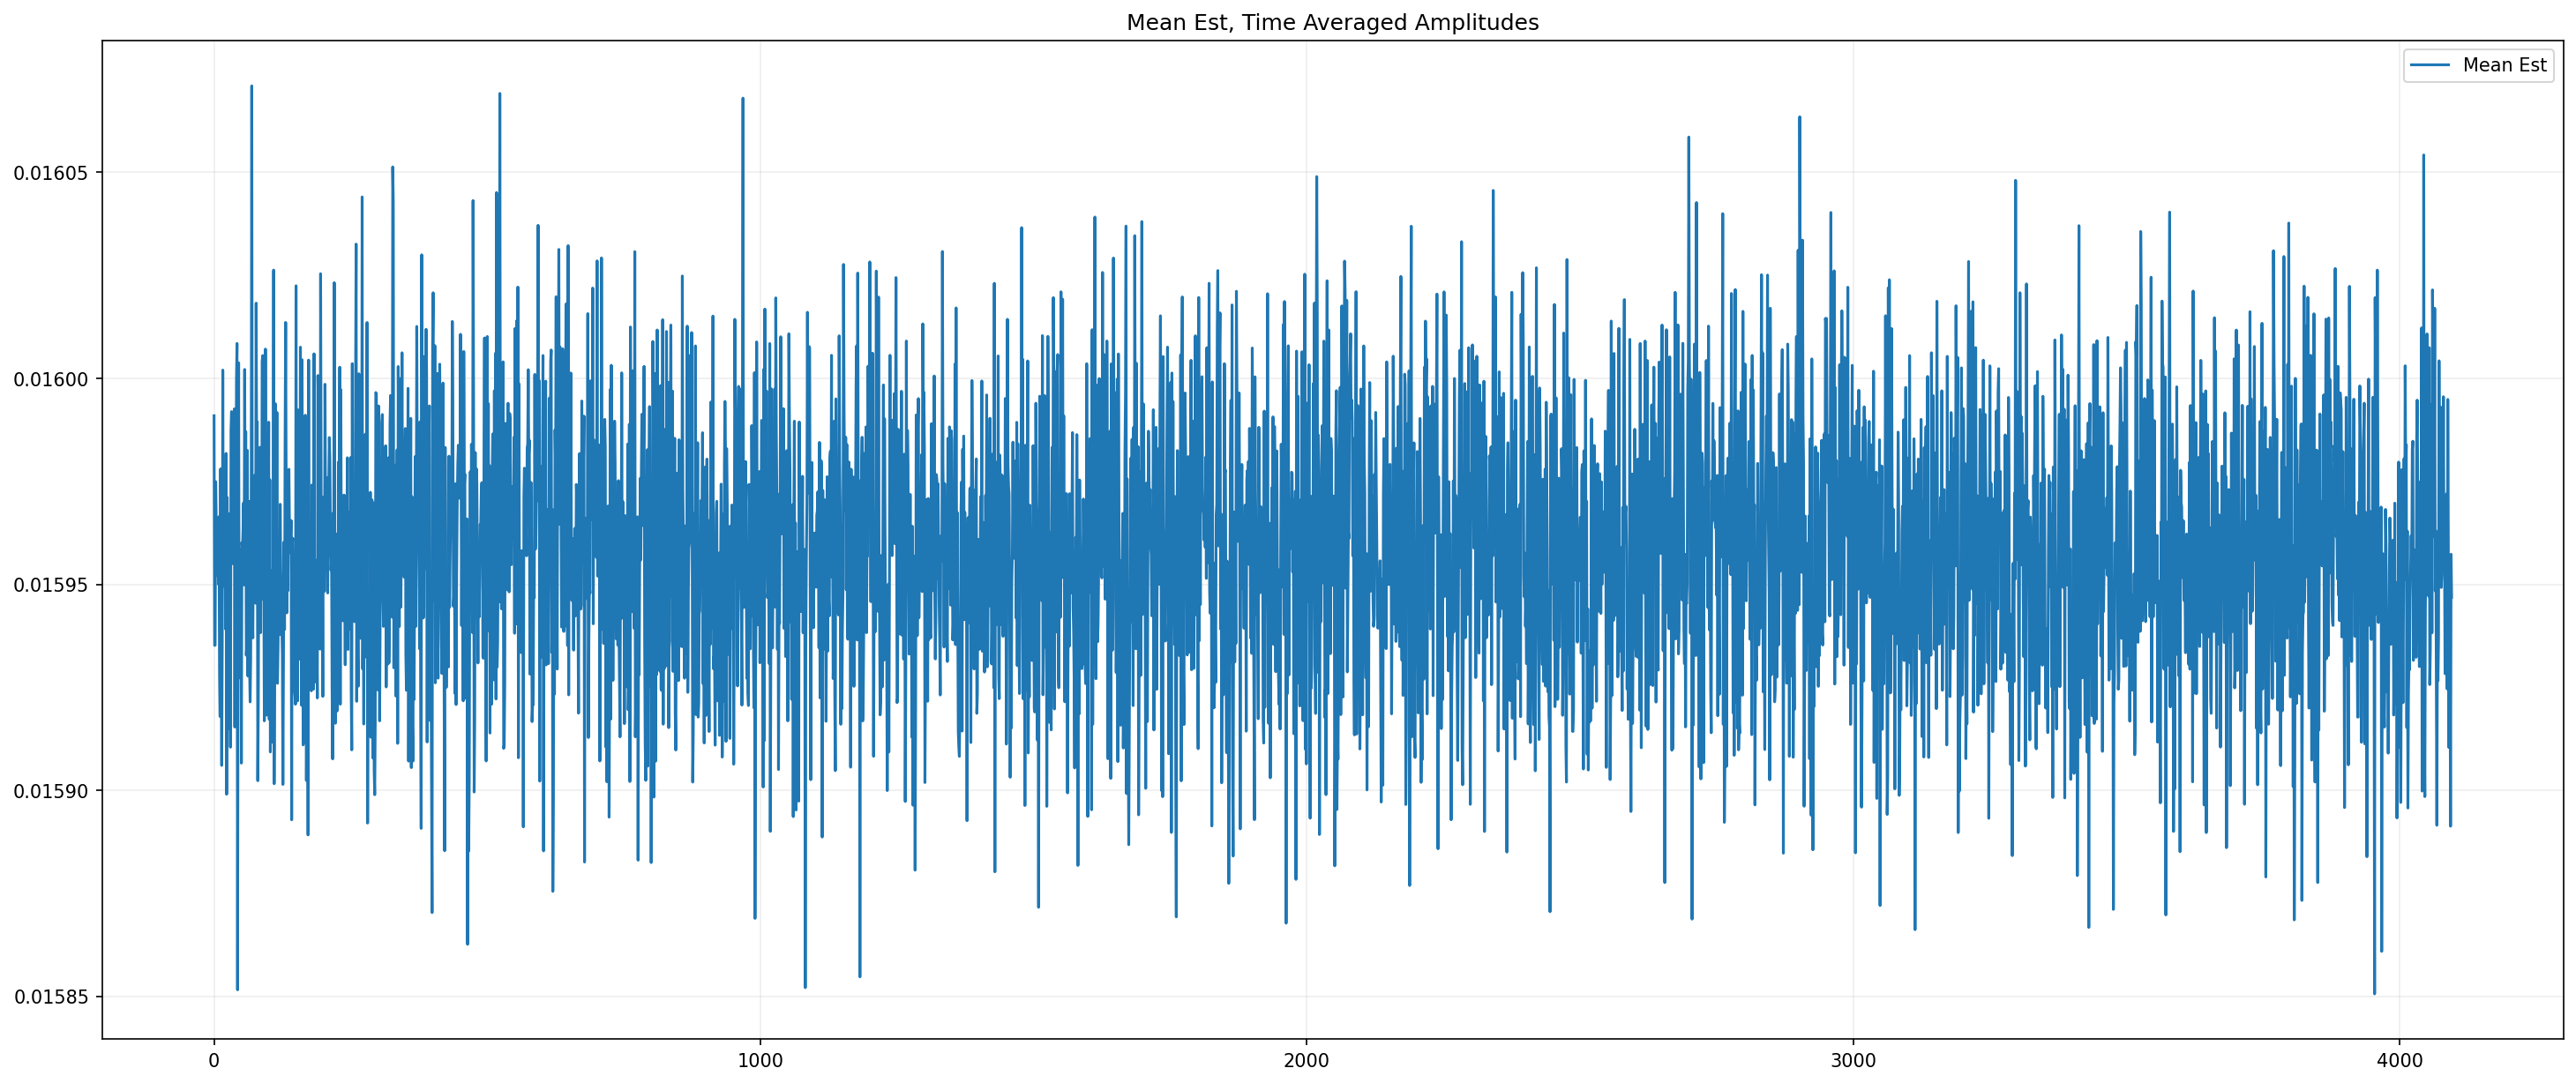

In [139]:
figure, ax = plt.subplots(1, 1 , figsize=(24, 10), dpi=150)

plot(meanEst, label= 'Mean Est', Title='Mean Est, Time Averaged Amplitudes', ax=ax) 

### Investigating when the Central Limit Theorem (CLT) Breaks

Below we have plotted the Monte Carlo Simulation distributions, in these simulations we vary the antenna number parameter N. We change the number of antennas to determine when the CLT has not been reached for the simulated SSINS Methodology. This will allow us to determine if we have enough antennas when applying the SSINS methodology to MeerKLASS data to allow for the CLT to have being approached. 

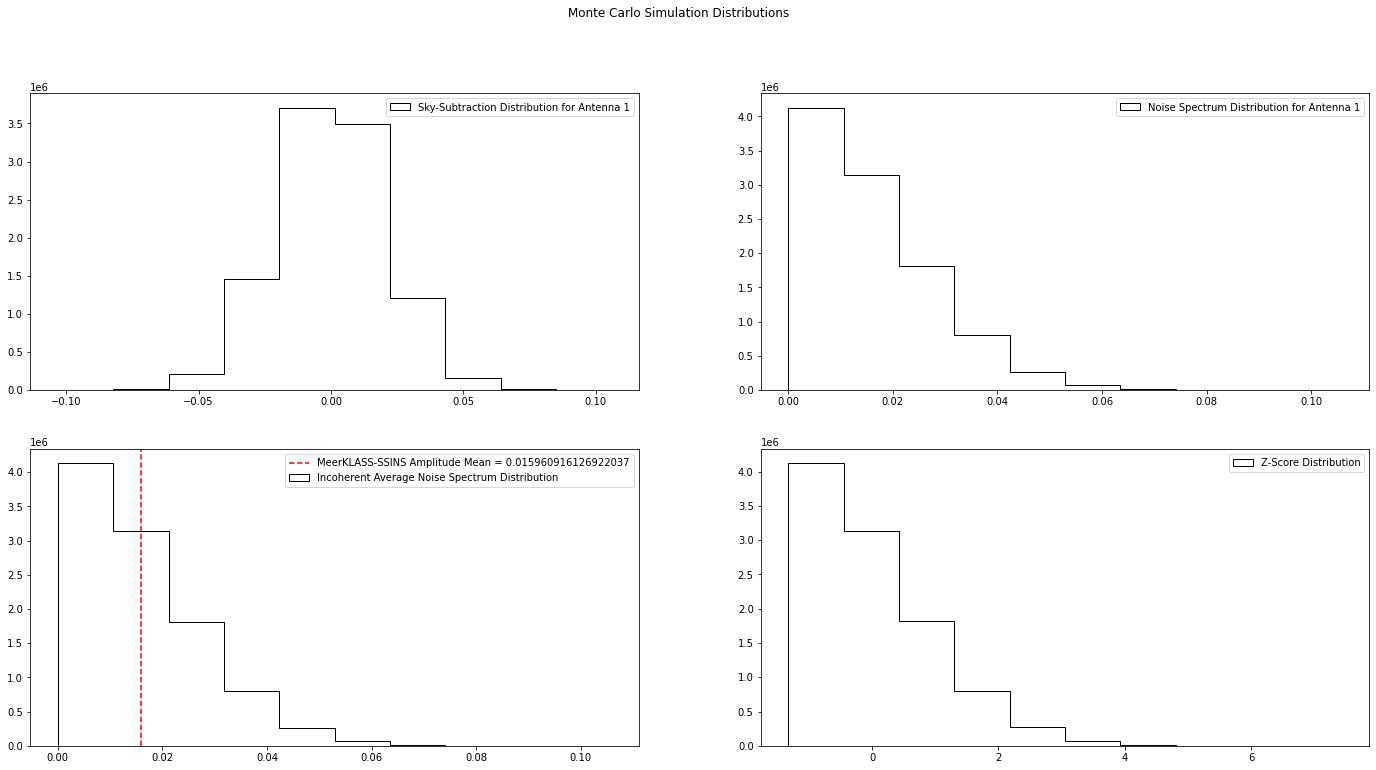

In [148]:
fig, ax = plt.subplots(2,2 ,figsize=(24,12))
ax = ax.flatten()
fig.suptitle('Monte Carlo Simulation Distributions')
plot_hist(np.ravel(sky_subs[0]), ax=ax[0], histtype='step', label='Sky-Subtraction Distribution for Antenna 1')
plot_hist(np.ravel(NS[0]), ax=ax[1], histtype='step', label='Noise Spectrum Distribution for Antenna 1')
plot_hist(np.ravel(INS), ax=ax[2], histtype='step', label='Incoherent Average Noise Spectrum Distribution')
ax[2].axvline(np.mean(INS), color='red', linestyle='--', label=f'MeerKLASS-SSINS Amplitude Mean = {np.mean(INS)}')
ax[2].legend()
plot_hist(np.ravel(z_score), ax=ax[3], histtype='step', label='Z-Score Distribution')


#plt.savefig('monte_sim_dist.png')
plt.show()

fig, ax = plt.subplots(2,2 ,figsize=(24,12))
ax = ax.flatten()
fig.suptitle('Monte Carlo Simulation Distributions')
plot_hist(np.ravel(sky_subs[0]), ax=ax[0], histtype='step', label='Sky-Subtraction Distribution for Antenna 2')
plot_hist(np.ravel(NS[0]), ax=ax[1], histtype='step', label='Noise Spectrum Distribution for Antenna 2')
plot_hist(np.ravel(INS), ax=ax[2], histtype='step', label='Incoherent Average Noise Spectrum Distribution')
ax[2].axvline(np.mean(INS), color='red', linestyle='--', label=f'MeerKLASS-SSINS Amplitude Mean = {np.mean(INS)}')
ax[2].legend()
plot_hist(np.ravel(z_score), ax=ax[3], histtype='step', label='Z-Score Distribution')


#plt.savefig('monte_sim_dist.png')
plt.show()

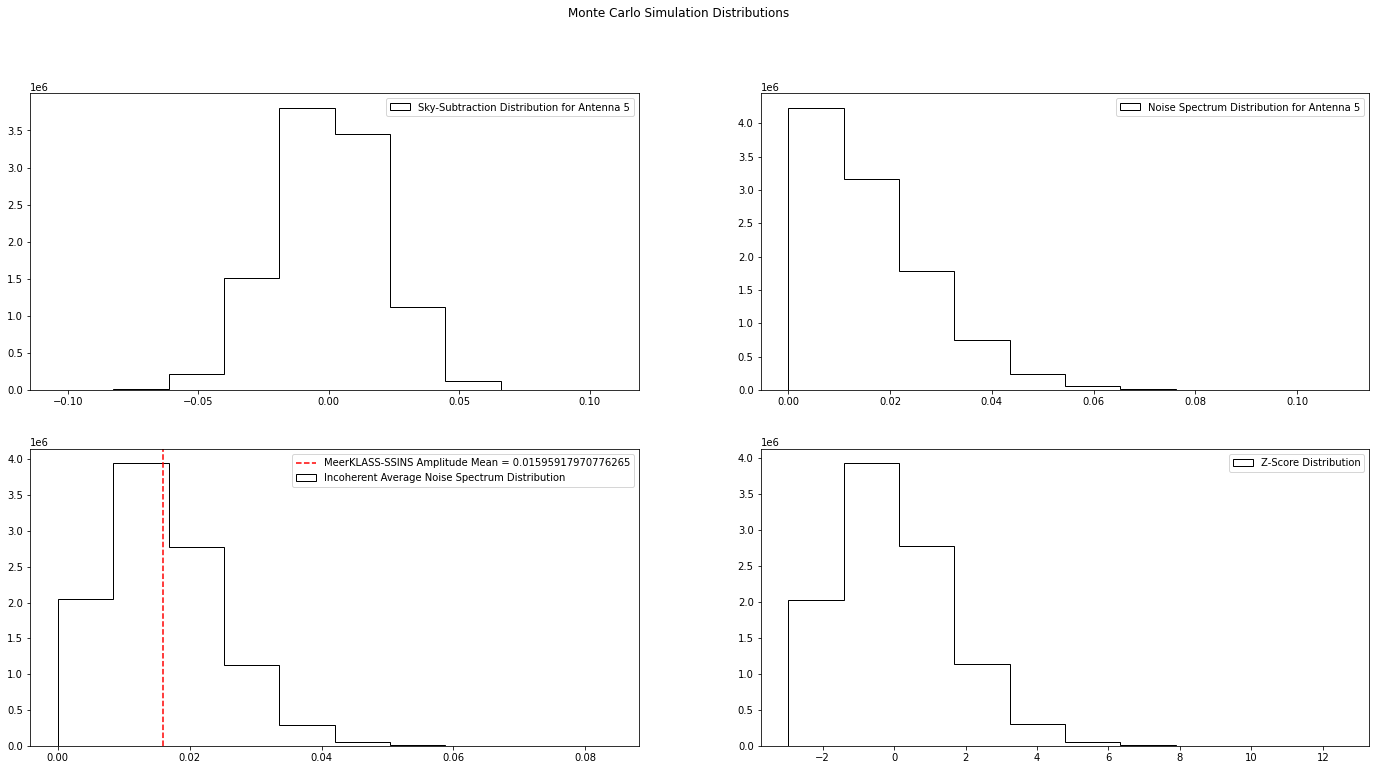

In [40]:
fig, ax = plt.subplots(2,2 ,figsize=(24,12))
ax = ax.flatten()
fig.suptitle('Monte Carlo Simulation Distributions')
plot_hist(np.ravel(sky_subs[0]), ax=ax[0], histtype='step', label='Sky-Subtraction Distribution for Antenna 5')
plot_hist(np.ravel(NS[0]), ax=ax[1], histtype='step', label='Noise Spectrum Distribution for Antenna 5')
plot_hist(np.ravel(INS), ax=ax[2], histtype='step', label='Incoherent Average Noise Spectrum Distribution')
ax[2].axvline(np.mean(INS), color='red', linestyle='--', label=f'MeerKLASS-SSINS Amplitude Mean = {np.mean(INS)}')
ax[2].legend()
plot_hist(np.ravel(z_score), ax=ax[3], histtype='step', label='Z-Score Distribution')
#plt.savefig('monte_sim_dist.png')
plt.show()

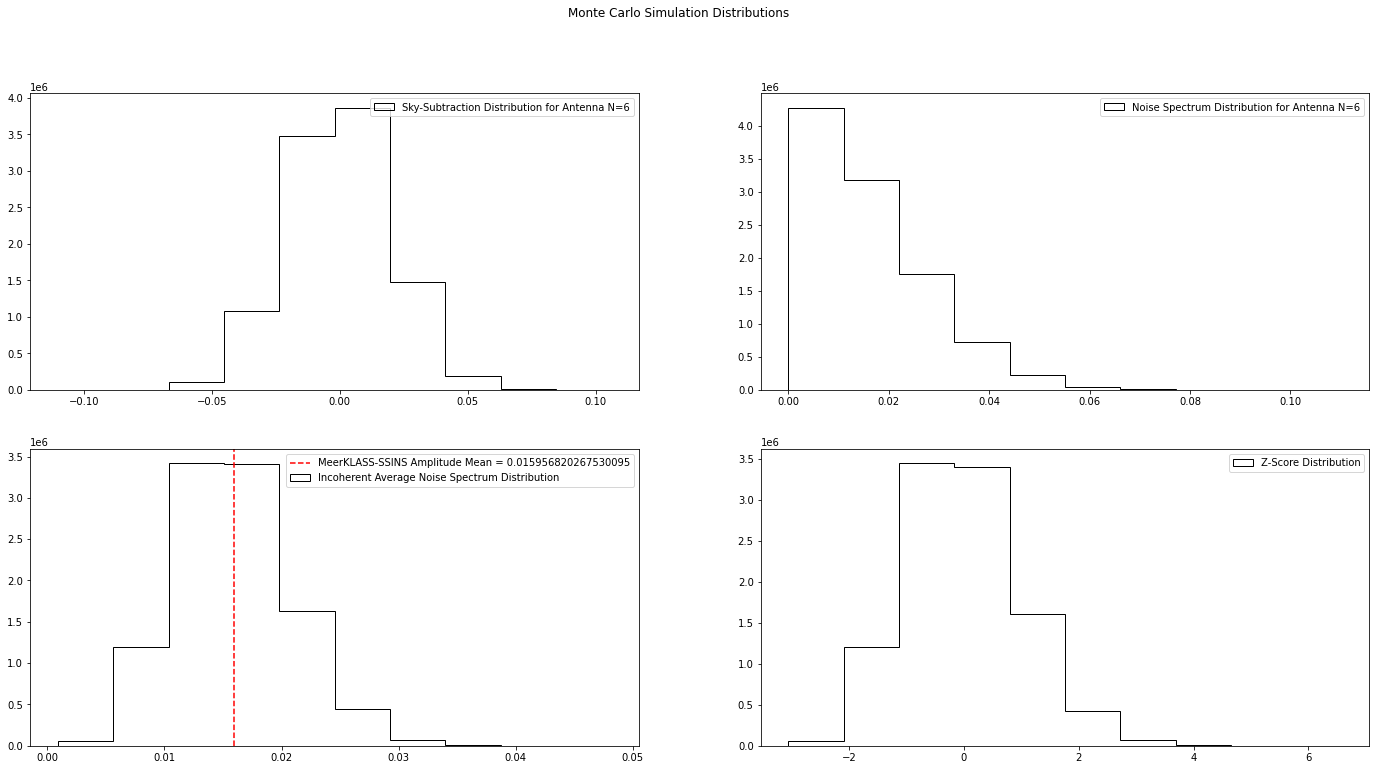

In [68]:
fig, ax = plt.subplots(2,2 ,figsize=(24,12))
ax = ax.flatten()
fig.suptitle('Monte Carlo Simulation Distributions')
plot_hist(np.ravel(sky_subs[0]), ax=ax[0], histtype='step', label='Sky-Subtraction Distribution for Antenna N=6')
plot_hist(np.ravel(NS[0]), ax=ax[1], histtype='step', label='Noise Spectrum Distribution for Antenna N=6')
plot_hist(np.ravel(INS), ax=ax[2], histtype='step', label='Incoherent Average Noise Spectrum Distribution')
ax[2].axvline(np.mean(INS), color='red', linestyle='--', label=f'MeerKLASS-SSINS Amplitude Mean = {np.mean(INS)}')
ax[2].legend()
plot_hist(np.ravel(z_score), ax=ax[3], histtype='step', label='Z-Score Distribution')
#plt.savefig('monte_sim_dist.png')
plt.show()

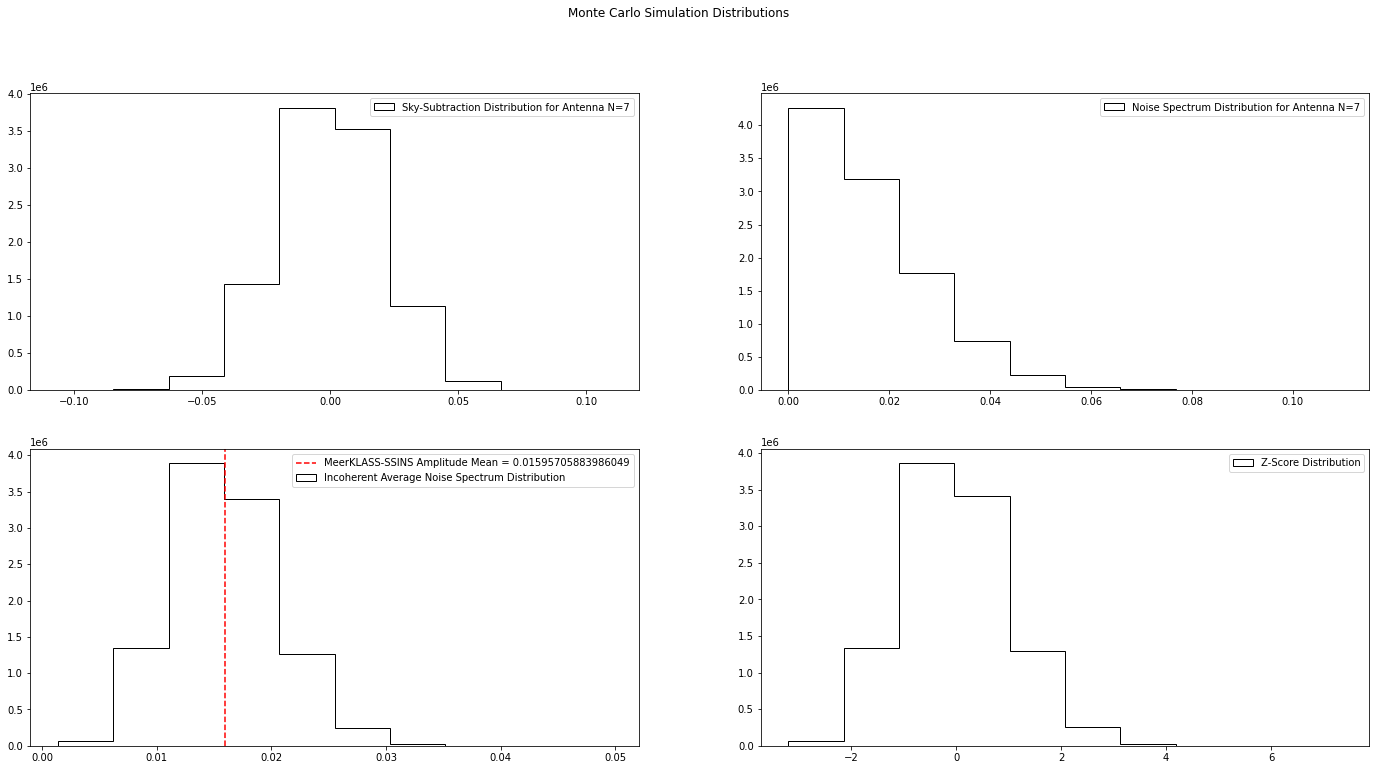

In [62]:
fig, ax = plt.subplots(2,2 ,figsize=(24,12))
ax = ax.flatten()
fig.suptitle('Monte Carlo Simulation Distributions')
plot_hist(np.ravel(sky_subs[0]), ax=ax[0], histtype='step', label='Sky-Subtraction Distribution for Antenna N=7')
plot_hist(np.ravel(NS[0]), ax=ax[1], histtype='step', label='Noise Spectrum Distribution for Antenna N=7')
plot_hist(np.ravel(INS), ax=ax[2], histtype='step', label='Incoherent Average Noise Spectrum Distribution')
ax[2].axvline(np.mean(INS), color='red', linestyle='--', label=f'MeerKLASS-SSINS Amplitude Mean = {np.mean(INS)}')
ax[2].legend()
plot_hist(np.ravel(z_score), ax=ax[3], histtype='step', label='Z-Score Distribution')
#plt.savefig('monte_sim_dist.png')
plt.show()

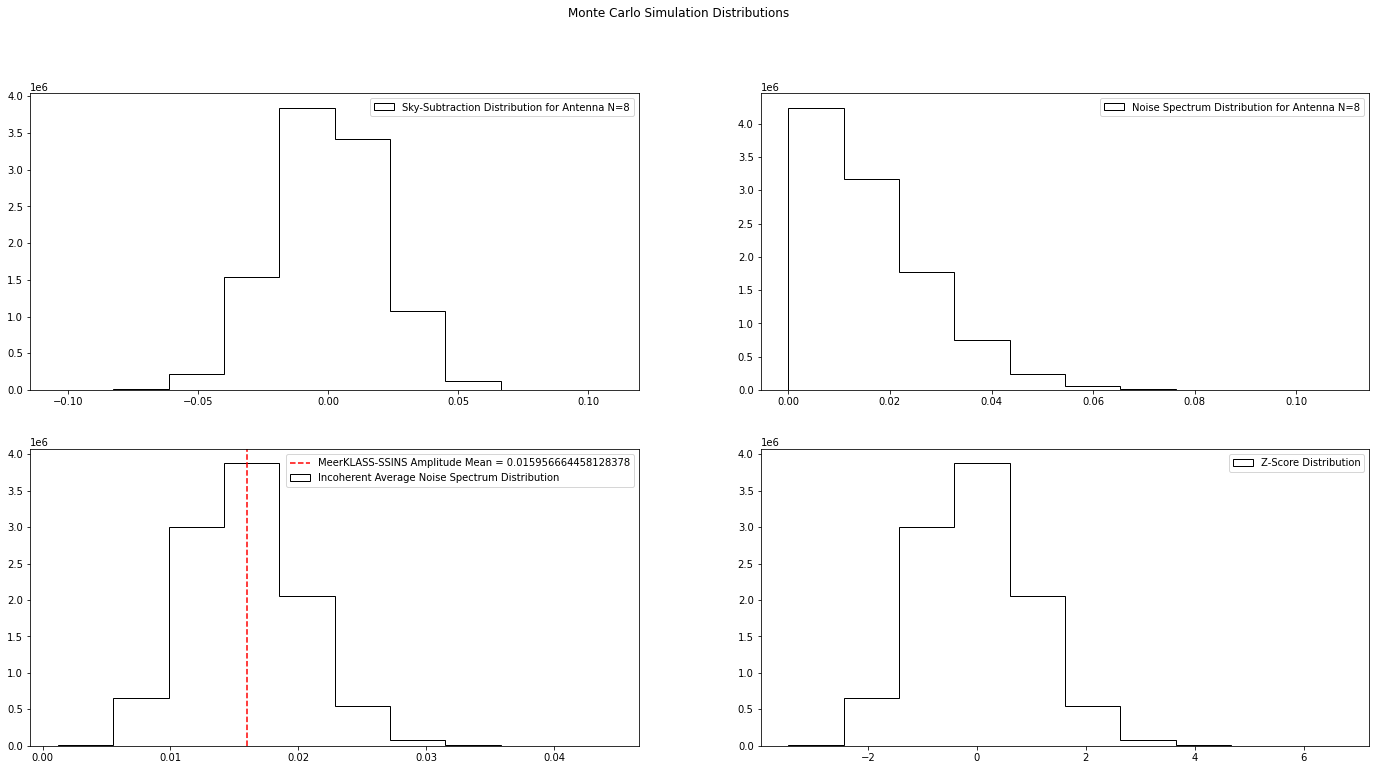

In [74]:
fig, ax = plt.subplots(2,2 ,figsize=(24,12))
ax = ax.flatten()
fig.suptitle('Monte Carlo Simulation Distributions')
plot_hist(np.ravel(sky_subs[0]), ax=ax[0], histtype='step', label='Sky-Subtraction Distribution for Antenna N=8')
plot_hist(np.ravel(NS[0]), ax=ax[1], histtype='step', label='Noise Spectrum Distribution for Antenna N=8')
plot_hist(np.ravel(INS), ax=ax[2], histtype='step', label='Incoherent Average Noise Spectrum Distribution')
ax[2].axvline(np.mean(INS), color='red', linestyle='--', label=f'MeerKLASS-SSINS Amplitude Mean = {np.mean(INS)}')
ax[2].legend()
plot_hist(np.ravel(z_score), ax=ax[3], histtype='step', label='Z-Score Distribution')
#plt.savefig('monte_sim_dist.png')
plt.show()

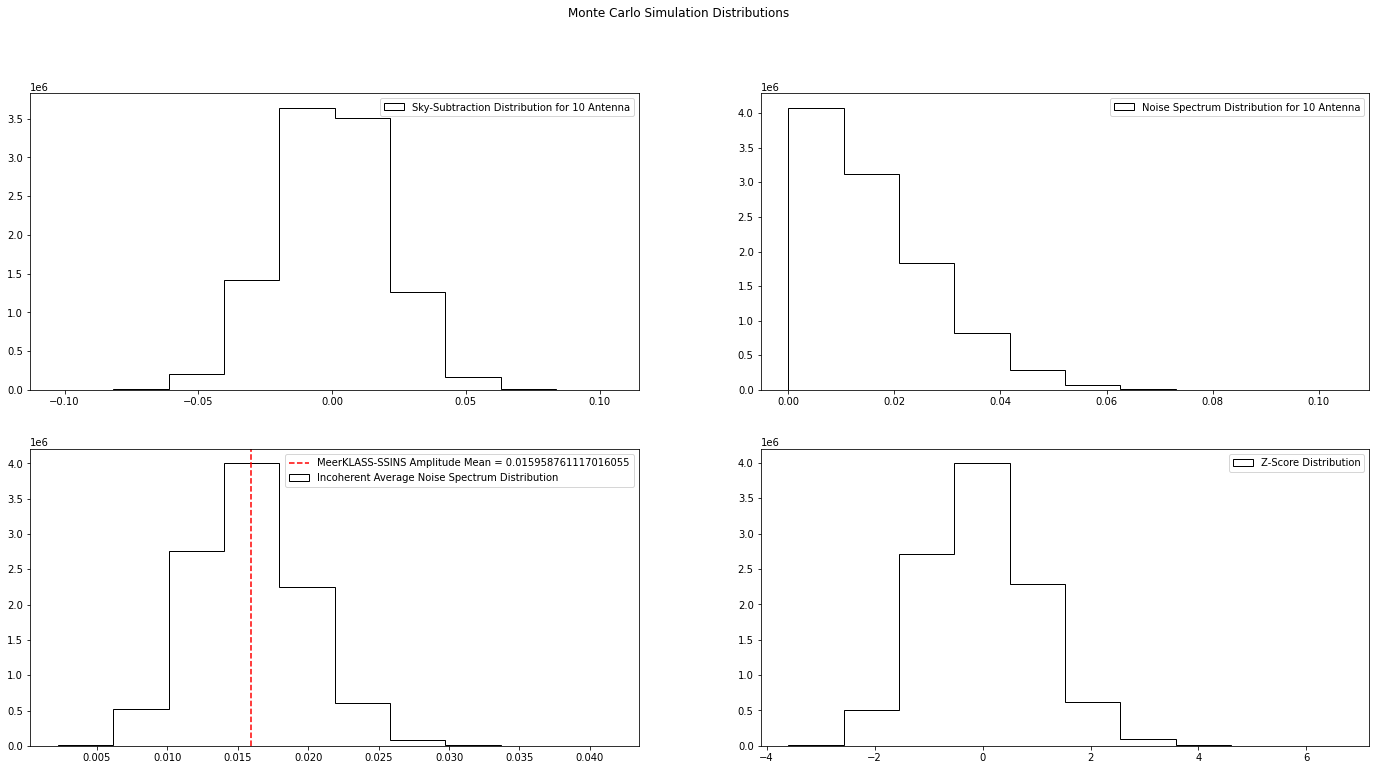

In [48]:
fig, ax = plt.subplots(2,2 ,figsize=(24,12))
ax = ax.flatten()
fig.suptitle('Monte Carlo Simulation Distributions')
plot_hist(np.ravel(sky_subs[0]), ax=ax[0], histtype='step', label='Sky-Subtraction Distribution for 10 Antenna')
plot_hist(np.ravel(NS[0]), ax=ax[1], histtype='step', label='Noise Spectrum Distribution for 10 Antenna')
plot_hist(np.ravel(INS), ax=ax[2], histtype='step', label='Incoherent Average Noise Spectrum Distribution')
ax[2].axvline(np.mean(INS), color='red', linestyle='--', label=f'MeerKLASS-SSINS Amplitude Mean = {np.mean(INS)}')
ax[2].legend()
plot_hist(np.ravel(z_score), ax=ax[3], histtype='step', label='Z-Score Distribution')


#plt.savefig('monte_sim_dist.png')
plt.show()

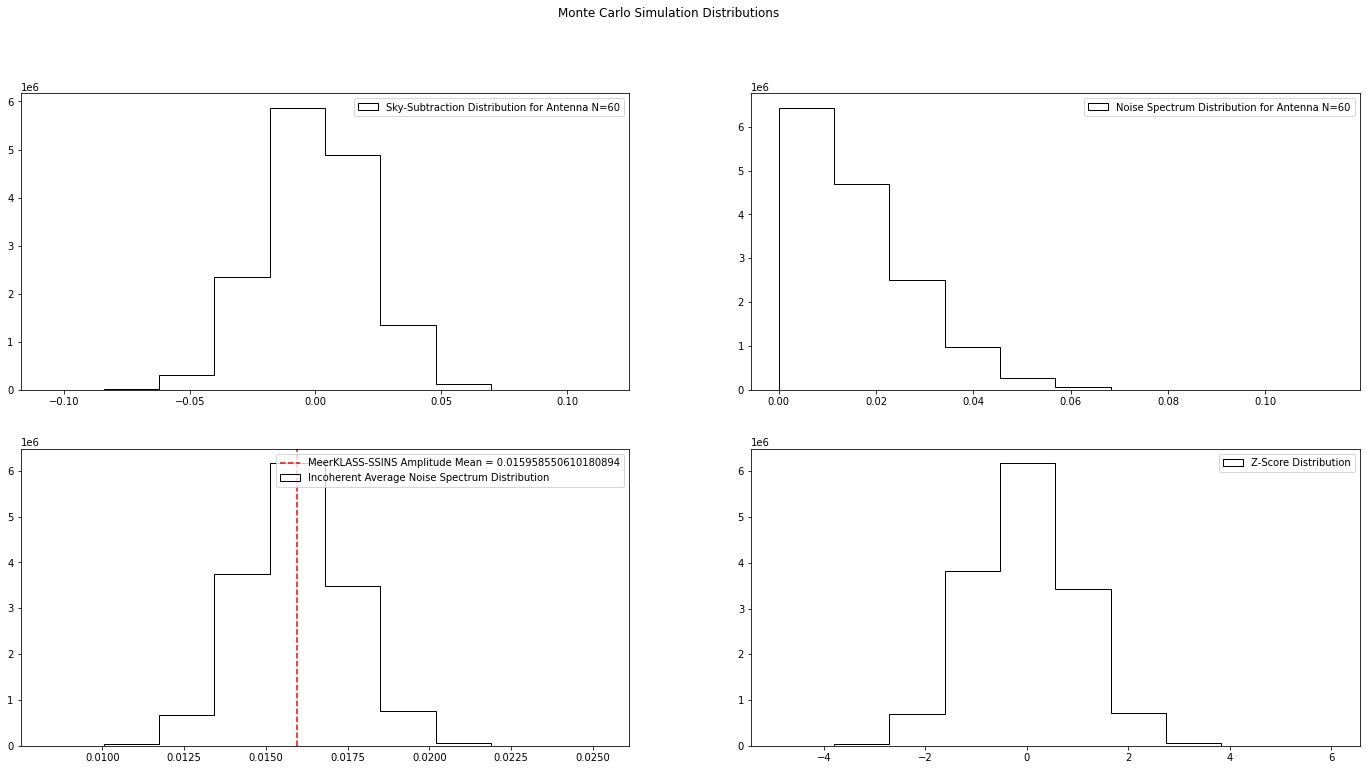

In [27]:
fig, ax = plt.subplots(2,2 ,figsize=(24,12))
ax = ax.flatten()
fig.suptitle('Monte Carlo Simulation Distributions')
plot_hist(np.ravel(sky_subs[0]), ax=ax[0], histtype='step', label='Sky-Subtraction Distribution for Antenna N=60')
plot_hist(np.ravel(NS[0]), ax=ax[1], histtype='step', label='Noise Spectrum Distribution for Antenna N=60')
plot_hist(np.ravel(INS), ax=ax[2], histtype='step', label='Incoherent Average Noise Spectrum Distribution')
ax[2].axvline(np.mean(INS), color='red', linestyle='--', label=f'MeerKLASS-SSINS Amplitude Mean = {np.mean(INS)}')
ax[2].legend()
plot_hist(np.ravel(z_score), ax=ax[3], histtype='step', label='Z-Score Distribution')


#plt.savefig('monte_sim_dist.png')
plt.show()

## Summary of CLT Invesitgation
In the above investigation we used a simple monte carlo simulation to determine if we have sufficient number of antennas when applying the SSINS method to MeerKLASS data, to allow the distributions to converge to Gaussian like distributions. 

1. N > 7 allows for CLT to kick-in :
In  the above plots we can spot that when we have N=1 (i.e one Antenna) the antenna averaged noise spectrum remains as a folded-gaussian, as we increase the number of antennas our baseline folded-gaussain slightly shifts to have the distribution peak centering closer to the mean.  From inspecting the plots we can establish that when we have < N=7 antennas the INS will not have reached CLT. Since at > N=8 the INS distribution shape does not change, as we kept on adding more antennas.

2. N= 197 (Full SKA Mid)
The antenna averaged noise spectrum distribution has relatively the same shape, and hence with N = 197 we expect CLT to be reached for MeerKLASS data. 


## Scipy Normality Tests of the Distributions

Check the normality of the Monte Carlo Simulated MeerKLASS noise amplitudes, the corresponding simultaed Antenna Averaged Noise SPectrum and Z-Score distributions using Scipy Kurtosis Tests.
Kurtosis: The following kurtosis tests provide a statistical measure (test statistics) that quantifies the shape of the probability distributions. These tests compare the peak and the tails of our samples to that of a normal distribution . A positive kurtosis indicates a more peaked dist with heavier tails that fall of rapidly, whilst a negative kurtosis indicates a flatter dist with lighter tails. 

Kurtosis also helps with identifying if there are outliers in the data. Since the tailedness of the distribution refers to how often ouliers occur.  A distribution with a longer tail indicates there are more outliers in the distribution. 

The peak of a distribution depends on the degree to which data values deviate from the mean, i.e decribes the concentration of data values around the mean. If there are more data values  that are centered around the mean the distribution will have a taller peak. This also indicates a smaller standard deviation, since values are closer to the mean.  

1. **Anderson-Darling Test**. The Anderson checks the null hypothesis that the sample follows a particular distribution, and in our case me want to check if the distribution follows a normal distribution. The testing criterion is given by the following critical values: [0.576, 0.656, 0.787, 0.918, 1.092] which corresponds to significance intervals of [15. , 10. ,  5. ,  2.5,  1. ] respectively.
   
2. **Kurtotsis Test**: This kurtosis tests, determines wether the null hypothesis, of a sample follows a normal distribution, and the test statistic determines wether the null hypothesis should either be rejected or accepted. By definition kurtosis is the tailedness of the distribution. It quantifies the 'heaviness' of the tails, for example a postive large kurtosis test statisctic indicates that the distibution is peaked and heavy tails, whilst a low and negative kurtosis suggests a flatter distribution with light tails. The tails is indicative of outliers.

   
3. **Kolmogorov Smirnov (KS)**: This test works similarly to the anderson darling test, it compares wether the distribution follows a normal distibution

### Summary Table of Kurtosis Results


| Distribution| Anderson Darling | Kurtosis Test Statistic| KS|
| --- | --- | --- | --- |
| Sky - Subtraction | 0.1980956494808197 | -0.19117035556416612 | 0.4751599193037573 | 
| Antenna Averaged Noise Spectrum | 1851.3483744878322 | 10.102207970518878 | 0.5041458145596083 | 
| Z- Score | 1879.3808312285691 | 6.410969611831604 | 0.00408893144471284| 

From the kurtosis tests we can conclude that the monte carlo noise (ideal sky subtractions) have guassian distributions. And the Incoherent Noise spectrum has a high-positive kurtosis, this indicates that is is highly peaked, however since this is ideal noise (i.e without RFI) the distribution does not have a very distinct tail, in comparision to the INS that we calculated using the SSINS method on MeerKLASS data, which shows a peaked INS that has a tail that has a tail that falls of rapidly (i.e a heavy tail in the distribution that is often an indicator of outliers).  

In [8]:
import scipy
from scipy.stats import kurtosistest, kstest, anderson, shapiro

In [184]:
test_stat = anderson(np.ravel(INS))
print(f':{test_stat}')

:AndersonResult(statistic=1851.3483744878322, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [19]:
test_stat = anderson(np.ravel(z_score))
print(f':{test_stat}')

:AndersonResult(statistic=1879.3808312285691, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [185]:
test_stat = kurtosistest(np.ravel(sky_subs[0]))
print(f':{test_stat}')

:KurtosistestResult(statistic=-0.19117035556416612, pvalue=0.8483921281024426)


In [18]:
test_stat = kurtosistest(np.ravel(INS))
print(f':{test_stat}')

:KurtosistestResult(statistic=10.102207970518878, pvalue=5.401217718153007e-24)


In [9]:
test_stat = kurtosistest(np.ravel(z_score))
print(f':{test_stat}')

:KurtosistestResult(statistic=6.410969611831604, pvalue=1.445970194959719e-10)


In [12]:
test_stat = kstest(np.ravel(sky_subs[0]), 'norm', alternative='less')
print(f':{test_stat}') # test stats, the sample is not normally dist.

:KstestResult(statistic=0.4751599193037573, pvalue=0.0)


In [13]:
test_stat = kstest(np.ravel(INS), 'norm', alternative='less')
print(f':{test_stat}') # test stats, the sample is not normally dist.

:KstestResult(statistic=0.5041458145596083, pvalue=0.0)


In [14]:
test_stat = kstest(np.ravel(z_score), 'norm', alternative='less')
print(f':{test_stat}') # test stats, the sample is not normally dist.

:KstestResult(statistic=0.00408893144471284, pvalue=1.954144951048871e-149)
